# Load Dataset

In [25]:
import pandas as pd
import numpy as np
sal = pd.read_csv("ds_salaries.csv",index_col=0)
sal.head()

,work_year,experience_level,employment_type,job_title,salary,salary_currency,salary_in_usd,employee_residence,remote_ratio,company_location,company_size
0,2020,MI,FT,Data Scientist,70000,EUR,79833,DE,0,DE,L
1,2020,SE,FT,Machine Learning Scientist,260000,USD,260000,JP,0,JP,S
2,2020,SE,FT,Big Data Engineer,85000,GBP,109024,GB,50,GB,M
3,2020,MI,FT,Product Data Analyst,20000,USD,20000,HN,0,HN,S
4,2020,SE,FT,Machine Learning Engineer,150000,USD,150000,US,50,US,L


In [26]:
sal.shape

(607, 11)

In [27]:
sal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 607 entries, 0 to 606
Data columns (total 11 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   work_year           607 non-null    int64 
 1   experience_level    607 non-null    object
 2   employment_type     607 non-null    object
 3   job_title           607 non-null    object
 4   salary              607 non-null    int64 
 5   salary_currency     607 non-null    object
 6   salary_in_usd       607 non-null    int64 
 7   employee_residence  607 non-null    object
 8   remote_ratio        607 non-null    int64 
 9   company_location    607 non-null    object
 10  company_size        607 non-null    object
dtypes: int64(4), object(7)
memory usage: 56.9+ KB


# Exploratory Data Analysis

Text(0.5, 1.0, 'Target Distribution')

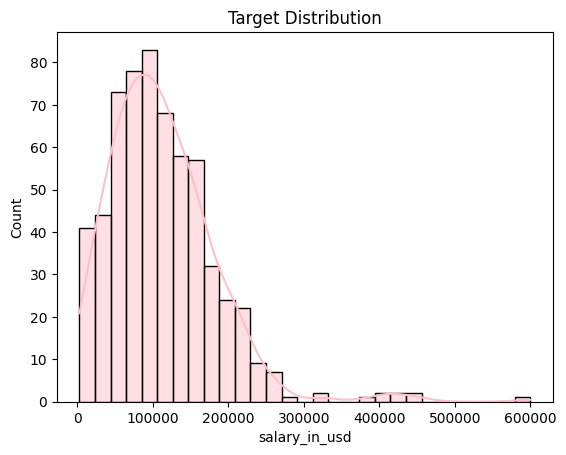

In [28]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.histplot(x=sal["salary_in_usd"],kde=True,color="pink")
plt.title("Target Distribution")

<Axes: title={'center': 'Outliers'}, xlabel='salary_in_usd'>

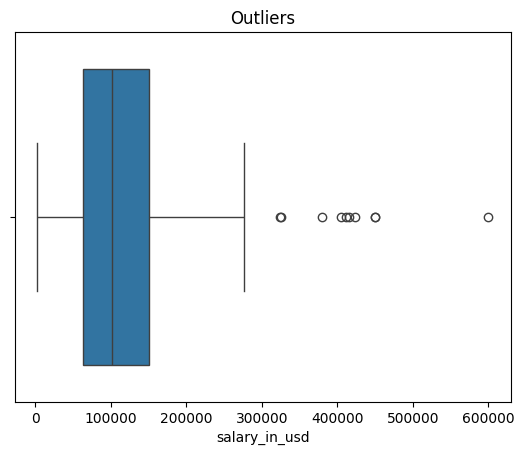

In [29]:
plt.title("Outliers")
sns.boxplot(x=sal["salary_in_usd"])

<Axes: title={'center': 'EXperience vs salary'}, xlabel='experience_level', ylabel='salary'>

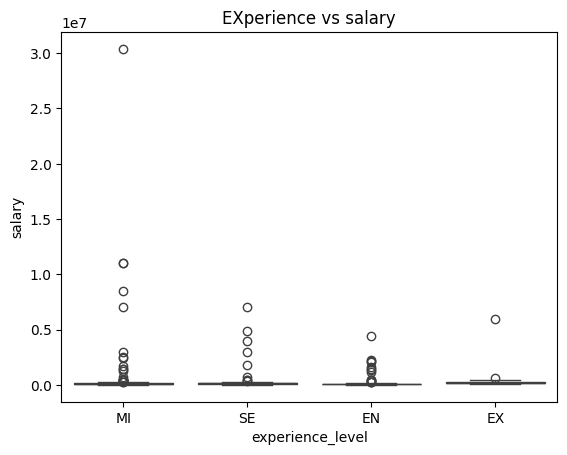

In [30]:
plt.title("EXperience vs salary")
sns.boxplot(x="experience_level",y="salary",data=sal)

<Axes: title={'center': 'Correlation HeatMap'}>

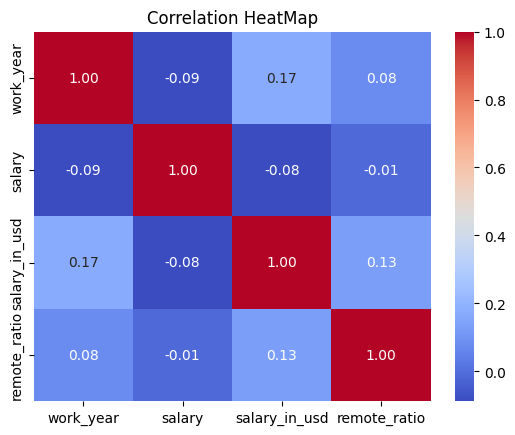

In [31]:
plt.title("Correlation HeatMap")
num = sal.select_dtypes(include=["int64"])
sns.heatmap(num.corr(),annot=True,fmt=".2f",cmap="coolwarm")

# Data Cleaning and Preprocessing

In [32]:
sal.isnull().sum()

work_year             0
experience_level      0
employment_type       0
job_title             0
salary                0
salary_currency       0
salary_in_usd         0
employee_residence    0
remote_ratio          0
company_location      0
company_size          0
dtype: int64

In [33]:
sal = sal.drop(["salary","salary_currency"],axis="columns")

X = sal.drop("salary_in_usd",axis=1)
y = np.log1p(sal["salary_in_usd"]) 
X.shape,y.shape

((607, 8), (607,))

**Identify Columns**

In [34]:
num_cols = X.select_dtypes(include=["int64"]).columns
cat_cols = X.select_dtypes(include=["object"]).columns

In [35]:
list(num_cols)

['work_year', 'remote_ratio']

In [36]:
list(cat_cols)

['experience_level',
 'employment_type',
 'job_title',
 'employee_residence',
 'company_location',
 'company_size']

# Training and Splitting

In [37]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Preprocessing PipeLine

In [38]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

In [39]:
preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", sparse_output=False), cat_cols)
    ]
)

In [40]:
X_train_prep = preprocess.fit_transform(X_train)
X_test_prep  = preprocess.transform(X_test)

In [41]:
X_train_prep.shape

(485, 151)

# Build a Sequential Model

In [42]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

In [43]:
stop = EarlyStopping(monitor="val_loss",patience=8,restore_best_weights=True)

model = Sequential([
    Dense(128, activation="relu", input_shape=(X_train_prep.shape[1],)),
    Dropout(0.1),
    Dense(64, activation="relu"),
    Dense(1)
])

In [44]:
model.compile(
    optimizer="adam",
    loss="mse",
    metrics=["mae"]
)

In [45]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               19456     
                                                                 
 dropout_1 (Dropout)         (None, 128)               0         
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 27,777
Trainable params: 27,777
Non-trainable params: 0
_________________________________________________________________


In [46]:
trained_model = model.fit(
    X_train_prep, y_train,
    validation_split=0.2,
    epochs=100,
    batch_size=32,
    callbacks=[stop],
    verbose=1
)

Epoch 1/100
13/13 [==============================] - 2s 36ms/step - loss: 111.7095 - mae: 10.5325 - val_loss: 89.7702 - val_mae: 9.4457
Epoch 2/100
13/13 [==============================] - 0s 10ms/step - loss: 71.7764 - mae: 8.4083 - val_loss: 45.1014 - val_mae: 6.6692
Epoch 3/100
13/13 [==============================] - 0s 10ms/step - loss: 25.0828 - mae: 4.7799 - val_loss: 5.8334 - val_mae: 2.1564
Epoch 4/100
13/13 [==============================] - 0s 11ms/step - loss: 2.3773 - mae: 1.2907 - val_loss: 3.4315 - val_mae: 1.6448
Epoch 5/100
13/13 [==============================] - 0s 11ms/step - loss: 2.6080 - mae: 1.3453 - val_loss: 1.5520 - val_mae: 0.8438
Epoch 6/100
13/13 [==============================] - 0s 10ms/step - loss: 1.0633 - mae: 0.7940 - val_loss: 1.9373 - val_mae: 1.0143
Epoch 7/100
13/13 [==============================] - 0s 11ms/step - loss: 0.8256 - mae: 0.7118 - val_loss: 1.0760 - val_mae: 0.6804
Epoch 8/100
13/13 [==============================] - 0s 10ms/step - l

# Evaluate Model

In [47]:
test_loss, test_mae = model.evaluate(X_test_prep, y_test, verbose=2)
test_mae


4/4 - 0s - loss: 0.5381 - mae: 0.4829 - 56ms/epoch - 14ms/step


0.4828573167324066

# Predictions

In [48]:
y_pred_log = model.predict(X_test_prep).squeeze()

y_pred = np.expm1(y_pred_log)   # inverse log
y_true = np.expm1(y_test.values)

import pandas as pd

pd.DataFrame({
    "Actual": y_true[:10],
    "Predicted": y_pred[:10]
})

4/4 [==============================] - 0s 3ms/step


,Actual,Predicted
0,140250.0,144585.984375
1,135000.0,144585.984375
2,100000.0,83116.101562
3,270000.0,87708.492188
4,26005.0,47278.003906
5,153000.0,150922.609375
6,51321.0,82141.257812
7,49646.0,34211.578125
8,76940.0,49479.683594
9,59102.0,18417.603516


Text(0.5, 1.0, 'Actual vs Predicted Salary')

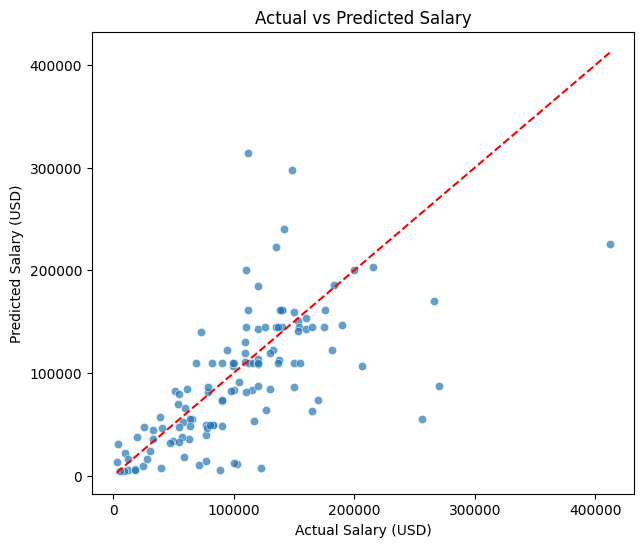

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7,6))
sns.scatterplot(x=y_true, y=y_pred, alpha=0.7)

max_val = max(y_true.max(), y_pred.max())
min_val = min(y_true.min(), y_pred.min())
plt.plot([min_val, max_val], [min_val, max_val], 'r--')

plt.xlabel("Actual Salary (USD)")
plt.ylabel("Predicted Salary (USD)")
plt.title("Actual vs Predicted Salary")

# Thank you 🙂